In [1]:
# dependencies

# to enable toolbars for plots
%matplotlib notebook

# add project base path to system path
import os
import sys

# need to append project root before importing other in package dependencies
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# json loading
import json

# url crawling
import urllib.request

# for time string manipulation
import datetime

import os
from os import listdir
from os.path import isfile, join, isdir

# numpy
import numpy as np

# python debugger
import pdb

# plotting
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d # for 3D plots

# pandas
import pandas as pd

# pretty printer
import pprint

# remove unneeded columns
from data_handling.remove_unneeded_columns import f_remove_unneeded_columns

# for getting station info
from data_handling.data_loading_methods import *

In [2]:
# load this dataset
filetoload = 'U:\\bluebikes\\station data 2022 03\\alldata.csv'

# read csv into df
alldata_df = pd.read_csv(filetoload, index_col=0)

C:\anaconda39\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# test
print(alldata_df.index)

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            3152223, 3152224, 3152225, 3152226, 3152227, 3152228, 3152229,
            3152230, 3152231, 3152232],
           dtype='int64', length=3152233)


In [4]:
# convert the time to datetime format
alldata_df['last_reported'] = pd.to_datetime( alldata_df['last_reported'], unit='s' )
# alldata_df.set_index('last_reported', inplace=True)

# calculate capacity ratio and add that as a column
alldata_df['capacity_ratio'] = alldata_df['num_bikes_available']/alldata_df['capacity']

In [5]:
# group by station id and calculate mean for each column
data_avg_by_id = alldata_df.groupby(['station_id']).mean()
data_std_by_id = alldata_df.groupby(['station_id']).std()

<IPython.core.display.Javascript object>


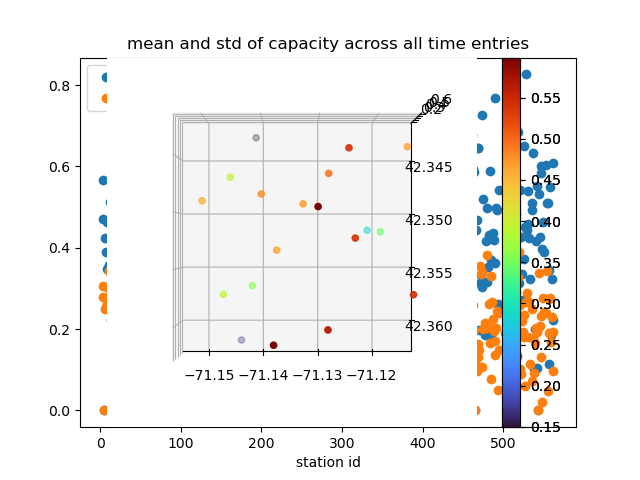

In [6]:
# plot avg and std
plt.scatter( data_avg_by_id.index, data_avg_by_id['capacity_ratio'] )
plt.scatter( data_std_by_id.index, data_std_by_id['capacity_ratio'] )

plt.legend(['average', 'std'])
plt.title('mean and std of capacity across all time entries')
plt.xlabel('station id')

plt.show()

station_id
3      False
4      False
5      False
6      False
7      False
       ...  
558    False
559    False
560    False
561    False
562    False
Length: 433, dtype: bool
station_id
3     -71.100619
4     -71.069616
5     -71.090179
6     -71.065287
7     -71.044571
         ...    
558   -71.101246
559   -71.193442
560   -71.087676
561   -71.044670
562   -70.890333
Name: lon, Length: 433, dtype: float64


<IPython.core.display.Javascript object>


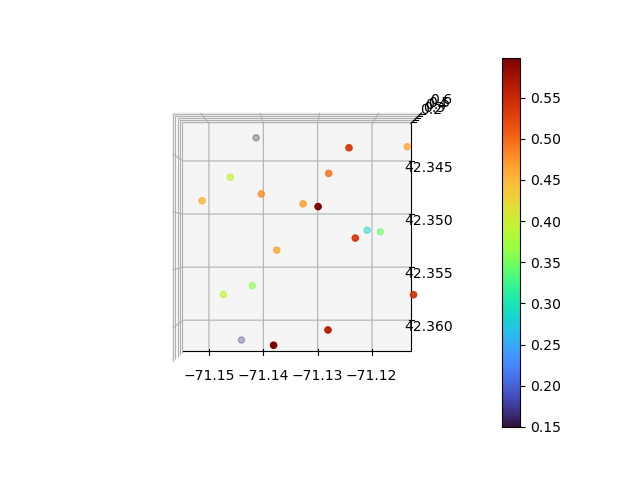

station_id
66   -71.132753
Name: lon, dtype: float64
station_id
66    42.349225
Name: lat, dtype: float64


In [20]:
# try a 3D plot of avg capacity vs. lat and long

# set the limits within some specified rectangular area

# this covers most of boston
# topleft = ( -71.155715, 42.365786  ) # watertown x,y or lon,lat
# botright = ( -71.066501, 42.338472  )

# this covers most of allston
topleft = ( -71.153907, 42.362498 ) # watertown v2
botright = ( -71.113694, 42.341907 ) # somewhere in brookline

indx_inlon = ( data_avg_by_id.lon >= topleft[0] )  & ( data_avg_by_id.lon <= botright[0] )
indx_inlat = ( data_avg_by_id.lat <= topleft[1] ) & ( data_avg_by_id.lat >= botright[1] )
indx_inarea = indx_inlon & indx_inlat

print(indx_inarea)

print(data_avg_by_id.lon)

fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.scatter3D(data_avg_by_id.lon.loc[indx_inarea], 
                 data_avg_by_id.lat.loc[indx_inarea], 
                 data_avg_by_id['capacity_ratio'].loc[indx_inarea], 
                 c=data_avg_by_id['capacity_ratio'].loc[indx_inarea], 
                 cmap='turbo');


plt.xlim([ topleft[0], botright[0] ])
plt.ylim([ topleft[1], botright[1] ])

# add a colorbar
# plt.colorbar( mappable = data_avg_by_id['capacity_ratio'] )
fig.colorbar(p)

# plot top down view
ax.view_init(90,-90)

# for myself, print out what lat and lon of station 66 is
print( data_avg_by_id.lon.loc[ data_avg_by_id.index == 66 ] )
print( data_avg_by_id.lat.loc[ data_avg_by_id.index == 66 ] )

In [12]:
# i want to get mean by hour of day and station

# first i think i need to add an hour of day column to the full dataset
alldata_df['hour'] = alldata_df['last_reported'].dt.hour

print(alldata_df['hour'])

0          14
1          14
2           0
3          14
4          14
           ..
3152228     3
3152229     2
3152230    23
3152231     3
3152232     3
Name: hour, Length: 3152233, dtype: int64


In [31]:
# now see if we can group on station and hour

alldata_groupedby_id_hour = alldata_df.groupby(['station_id','hour'])

# debug
# print(alldata_groupedby_id_hour)

# get mean and std
# mean_std_groupedby_id_hour = alldata_groupedby_id_hour.agg({'capacity_ratio':['mean','std']})
mean_std_groupedby_id_hour = alldata_groupedby_id_hour.agg(['mean','std']) # for all columns

# debug
# print(mean_std_groupedby_id_hour)

mean_std_groupedby_id_hour = mean_std_groupedby_id_hour.reset_index()

# debug
#print(mean_std_groupedby_id_hour['capacity_ratio']['mean'].loc[1])



0.3837440553393861


<IPython.core.display.Javascript object>


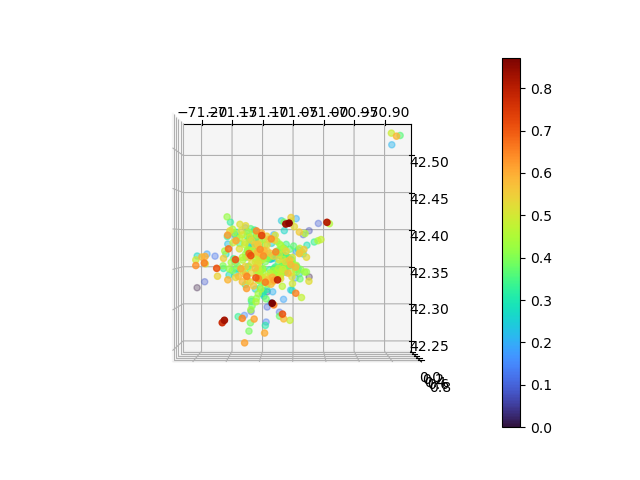

In [67]:
# now i want to plot just the mean capacity during a specific hour
hour_to_plot = 12
indx_wantedhour = mean_std_groupedby_id_hour['hour'] == hour_to_plot

# debugging
# print(indx_wantedhour)
# print(mean_std_groupedby_id_hour['lon']['mean'])
# print(mean_std_groupedby_id_hour['lon']['mean'].loc[mean_std_groupedby_id_hour])

fig = plt.figure()
ax  = plt.axes(projection='3d')
p = ax.scatter3D(mean_std_groupedby_id_hour['lon']['mean'].loc[indx_wantedhour], 
                 mean_std_groupedby_id_hour['lat']['mean'].loc[indx_wantedhour], 
                 mean_std_groupedby_id_hour['capacity_ratio']['mean'].loc[indx_wantedhour], 
                 c=mean_std_groupedby_id_hour['capacity_ratio']['mean'].loc[indx_wantedhour], 
                 cmap='turbo');

# add a colorbar
# plt.colorbar( mappable = data_avg_by_id['capacity_ratio'] )
fig.colorbar(p)

# plot top down view
ax.view_init(90,-90)

<IPython.core.display.Javascript object>


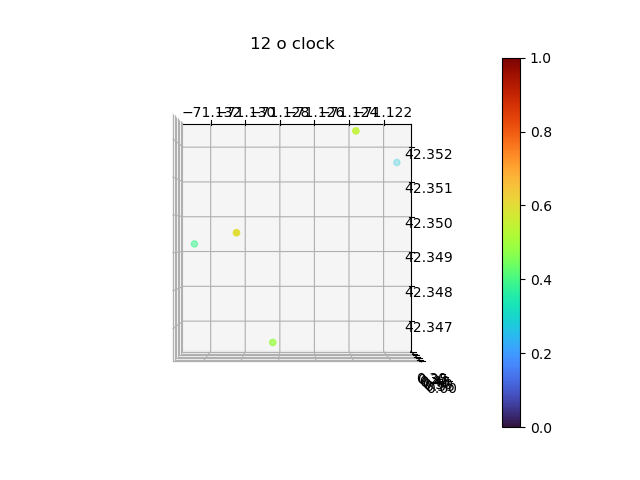

Text(0.5, 0.92, '12 o clock')

In [68]:
# plot just in local area

# this covers most of allston
# topleft = ( -71.153907, 42.362498 ) # lon, lat, watertown v2
# botright = ( -71.113694, 42.341907 ) # somewhere in brookline

# just my neighborhood
topleft = ( -71.137266, 42.354343 )
botright = ( -71.119995, 42.345254 )

indx_inlon = ( mean_std_groupedby_id_hour['lon']['mean'] >= topleft[0] )  & ( mean_std_groupedby_id_hour['lon']['mean'] <= botright[0] )
indx_inlat = ( mean_std_groupedby_id_hour['lat']['mean'] <= topleft[1] ) & ( mean_std_groupedby_id_hour['lat']['mean'] >= botright[1] )
indx_inarea = indx_inlon & indx_inlat & indx_wantedhour

fig = plt.figure()
ax  = plt.axes(projection='3d')
p = ax.scatter3D(mean_std_groupedby_id_hour['lon']['mean'].loc[indx_inarea], 
                 mean_std_groupedby_id_hour['lat']['mean'].loc[indx_inarea], 
                 mean_std_groupedby_id_hour['capacity_ratio']['mean'].loc[indx_inarea], 
                 c=mean_std_groupedby_id_hour['capacity_ratio']['mean'].loc[indx_inarea], 
                 cmap='turbo',
                vmin=0, vmax=1);

# add a colorbar
# plt.colorbar( mappable = data_avg_by_id['capacity_ratio'] )
fig.colorbar(p)

# plot top down view
ax.view_init(90,-90)

plt.title(str(hour_to_plot) + ' o clock')
